In [1]:
import pandas as pd
from cleantext import clean
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt 
import tensorflow as tf

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB

    
    
from wordcloud import WordCloud



2023-08-18 19:53:57.793992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Reading and cleaning the news sample 

In [2]:
df = pd.read_csv("news_sample.csv")

In [3]:
def clean_file(df:pd.DataFrame) -> (pd.DataFrame, str):
    """
        Takes a pandas Dataframe, and cleans the content. 
        
        Returns the new df with cleaned content, and a concatenated string of all the contents. 
    """
    i = 0
    concat_text = ""
    for text in df["content"]:
        if type(text) == str:
            date_reg = re.compile("\d{0,4}-\d{0,2}-\d{0,2}[^,]+") # Cleaning the Dates of the text
            date_subbed = date_reg.sub("<DAT>", text)
            date_reg2 = re.compile("/^(?:\d{4})-(?:\d{2})-(?:\d{2})T(?:\d{2}):(?:\d{2}):(?:\d{2}(?:\.\d*)?)(?:(?:-(?:\d{2}):(?:\d{2})|Z)?)$/")
            date_subbed2 = date_reg2.sub("<DAT>", date_subbed)
            cleaned_news_file = clean(date_subbed2,no_line_breaks=True, # Cleaning the rest of the text.
                    no_urls=True,                  
                    no_emails=True,                   
                    no_numbers=True,
                    no_punct=True,
                    replace_with_number = "<NUM>")
            df.loc[i,"content"] = cleaned_news_file # returning the cleaned text to the right position in our dataframe
            
            concat_text = concat_text + cleaned_news_file # Making a string with all the content.
        i += 1   
    return df, concat_text

In [4]:
df, news_file  = clean_file(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        250 non-null    int64  
 1   id                250 non-null    int64  
 2   domain            250 non-null    object 
 3   type              238 non-null    object 
 4   url               250 non-null    object 
 5   content           250 non-null    object 
 6   scraped_at        250 non-null    object 
 7   inserted_at       250 non-null    object 
 8   updated_at        250 non-null    object 
 9   title             250 non-null    object 
 10  authors           170 non-null    object 
 11  keywords          0 non-null      float64
 12  meta_keywords     250 non-null    object 
 13  meta_description  54 non-null     object 
 14  tags              27 non-null     object 
 15  summary           0 non-null      float64
dtypes: float64(2), int64(2), object(12)
memory u

In [6]:
df["type"].unique()

array(['unreliable', 'fake', 'clickbait', 'conspiracy', 'reliable',
       'bias', 'hate', 'junksci', 'political', nan, 'unknown'],
      dtype=object)

In [7]:
def tokenize(text):
    """
    Takes a string of text and tokenizes it. 
    
    Returns a list of the tokenized text. 
    
    """
    token_list = nltk.word_tokenize(text)
    words = [word for word in token_list if word.isalpha()]
    return words 

In [8]:
def removing_stopwords(token_list:list) -> list:
    """
    Takes a list of words and removes the stopwords 
    
    Returns a list of words
    """
    stop_words = set(stopwords.words('english'))
    words = [w for w in token_list if not w in stop_words]
    return words

In [9]:
def stemming(token_list:list) -> list:
    """
    Takes a list of words and stems the words
    
    Returns a list of stemmed words. 
    """
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in token_list]
    return stemmed 
    

In [10]:
def unique(list1):
    """
    Takes a list and drop all duplicates in the list
    
    Returns a list with no duplicates
    """
    unique_list = pd.Series(list1).drop_duplicates().tolist()
    return unique_list

In [11]:
news_file_tokens = tokenize(news_file) # Tokenizing the cleaned text 

In [12]:
news_file_tokens_no_stopwords = removing_stopwords(news_file_tokens) # Removing stopwords

In [13]:
news_file_stemmed = stemming(news_file_tokens_no_stopwords) # Stemming the list

In [14]:
unique_news_file_tokens = unique(news_file_tokens) # Only unique words 
unique_news_file_tokens_no_stopwords = unique(news_file_tokens_no_stopwords)
unique_news_file_stemmed = unique(news_file_stemmed)

I used the libraries cleantext, re and nltk.
I used re to use reg exp to clean the dates in our sample, because cleantext doesn't cleantext performed poorly if the dates wasn't cleaned before hand. 

Then I used cleantext to clean the basics such as lowercase, emails and numbers. 

After I had cleaned our text I used the nltk library for tokenizing the text, removing stopwords and stemming the text. 

We us pandas DataFrame for representing the dataset. Pandas dataframe is a very useful and powerful tool to explore datasets. 

## Exploring the news sample data set

In [15]:
print(f"Tokens after just tokenizing: {len(news_file_tokens)}")
print(f"Tokens after removing stopwords: {len(news_file_tokens_no_stopwords)}")
print(f"Tokens after stemming: {len(news_file_stemmed)}")
print(f"Unique tokens after just tokenizing: {len(unique_news_file_tokens)}")
print(f"Unique tokens after removing stopwords: {len(unique_news_file_tokens_no_stopwords)}")
print(f"Unique tokens after stemming: {len(unique_news_file_stemmed)}")

Tokens after just tokenizing: 169151
Tokens after removing stopwords: 95970
Tokens after stemming: 95970
Unique tokens after just tokenizing: 16540
Unique tokens after removing stopwords: 16408
Unique tokens after stemming: 11002


In [16]:
df["type"].unique()

array(['unreliable', 'fake', 'clickbait', 'conspiracy', 'reliable',
       'bias', 'hate', 'junksci', 'political', nan, 'unknown'],
      dtype=object)

In [17]:
## Dropping the "unknown" and nan types. 

a = ['rumor', 'hate', 'unreliable', 'conspiracy', 'clickbait', 'satire',
       'fake', 'reliable', 'bias', 'political', 'junksci']
df = df[df["type"].isin(a)]

In [18]:
## Dropping duplicate columns

df.drop_duplicates("content",inplace=True) 

In [19]:
## Making the labels for the articles. 

df_labels = df["type"].isin(["political", "reliable" , "clickbait"])

## Inserting the labels in the original Dataframe.
df.insert(loc = 16, column = "label",value = df_labels)     

In [20]:
df["content"] = df["content"].apply(tokenize)
df["content"] = df["content"].apply(removing_stopwords)
df["content"] = df["content"].apply(stemming)

df["content"] = df["content"].apply(" ".join)

In [21]:
print(f"Number of urls: {news_file_stemmed.count('url')}")
print(f"Number of dates: {news_file_stemmed.count('dat')}")
print(f"Number of numbers: {news_file_stemmed.count('num')}")
                        

Number of urls: 240
Number of dates: 17
Number of numbers: 2369


In [22]:
def word_count(token_list:list):
    """
    Takes a list of words, and counts the number of times the words appears in the list
    
    Returns a list with the words and the number of times they appeared in the list. 
    It is sorted in descending order
    """
    word_dic = {}
    for word in token_list:
        if word in word_dic:
            word_dic[word] += 1
        else:
            word_dic[word] = 1
    sorted_dic = (sorted(word_dic.items(), key = lambda x:x[1], reverse=True))
    return sorted_dic 

In [23]:
fake_list = ['rumor', 'hate', 'unreliable', 'conspiracy',  'satire',
       'fake',  'bias',  'junksci']

In [24]:
## Creating a Dataset containing only the articles labeled fake(false).
fake_data_set, fake_text = clean_file(df[df["type"].isin(fake_list)])
fake_data_set_stemmed = stemming(removing_stopwords(tokenize(fake_text)))

/tmp/ipykernel_189575/702756270.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i,"content"] = cleaned_news_file # returning the cleaned text to the right position in our dataframe


In [25]:
## Creating a Dataset containing only the articles labeled true.
true_data_set, true_text = clean_file(df[df["label"]==True])
true_data_set_stemmed = stemming(removing_stopwords(tokenize(true_text)))

/tmp/ipykernel_189575/702756270.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i,"content"] = cleaned_news_file # returning the cleaned text to the right position in our dataframe


In [26]:
## Making word count dictionaries 
token_word_count = word_count(news_file_tokens)
stemmed_word_count = word_count(news_file_stemmed)
fake_word_count = word_count(fake_data_set_stemmed)
true_word_count = word_count(true_data_set_stemmed)
## Deleting num from the dictionaries 
del stemmed_word_count[0]
del fake_word_count[0]
del true_word_count[0]

In [27]:
print(token_word_count[0:100])

[('the', 9459), ('of', 4956), ('to', 4883), ('and', 4690), ('a', 3375), ('in', 3099), ('num', 2369), ('is', 2314), ('that', 2202), ('for', 1548), ('it', 1338), ('are', 1232), ('with', 1157), ('on', 1150), ('this', 1149), ('you', 1139), ('as', 1084), ('be', 924), ('i', 869), ('by', 836), ('have', 787), ('not', 786), ('was', 782), ('at', 707), ('from', 706), ('or', 687), ('we', 622), ('they', 602), ('its', 592), ('but', 591), ('your', 555), ('has', 542), ('an', 518), ('their', 513), ('can', 497), ('all', 492), ('will', 487), ('more', 467), ('about', 461), ('if', 448), ('us', 446), ('one', 423), ('what', 419), ('who', 417), ('he', 417), ('were', 389), ('which', 388), ('so', 387), ('there', 377), ('people', 368), ('our', 362), ('his', 355), ('been', 344), ('no', 340), ('these', 336), ('like', 327), ('would', 321), ('do', 318), ('when', 303), ('trump', 297), ('time', 291), ('some', 282), ('also', 276), ('up', 271), ('new', 270), ('had', 268), ('out', 268), ('how', 261), ('blockchain', 260),

In [28]:
print(stemmed_word_count[0:100])

[('one', 463), ('us', 446), ('like', 406), ('peopl', 387), ('time', 385), ('state', 366), ('trump', 344), ('would', 321), ('use', 321), ('market', 294), ('year', 290), ('also', 276), ('new', 270), ('blockchain', 260), ('make', 258), ('url', 240), ('thing', 233), ('think', 231), ('go', 230), ('way', 228), ('said', 228), ('mani', 227), ('report', 227), ('govern', 225), ('even', 215), ('take', 212), ('next', 212), ('nation', 212), ('get', 211), ('see', 203), ('could', 200), ('presid', 200), ('work', 190), ('say', 190), ('stock', 188), ('two', 185), ('american', 184), ('world', 184), ('may', 184), ('need', 183), ('day', 182), ('first', 181), ('right', 180), ('life', 177), ('power', 169), ('want', 169), ('look', 164), ('help', 157), ('come', 156), ('countri', 153), ('well', 153), ('includ', 152), ('bitcoin', 151), ('feel', 151), ('fact', 149), ('person', 148), ('war', 147), ('bank', 146), ('obama', 146), ('good', 144), ('search', 143), ('much', 142), ('back', 140), ('sourc', 140), ('call', 

#### Its clear that the number of tokens is dramatically down, and more descriptive words start to show up as the most frequent words. Words like state, trump, market and blockchain.

In [29]:
print(fake_word_count[0:100])

[('one', 351), ('us', 331), ('like', 322), ('time', 297), ('peopl', 282), ('trump', 279), ('market', 276), ('state', 270), ('blockchain', 260), ('would', 257), ('use', 254), ('year', 233), ('also', 205), ('next', 197), ('make', 186), ('govern', 186), ('mani', 182), ('new', 182), ('stock', 180), ('nation', 180), ('even', 177), ('way', 175), ('report', 175), ('get', 171), ('see', 170), ('think', 170), ('could', 167), ('go', 162), ('may', 159), ('two', 153), ('take', 151), ('bitcoin', 151), ('world', 147), ('first', 145), ('said', 145), ('work', 143), ('search', 142), ('need', 141), ('day', 141), ('want', 139), ('thing', 138), ('look', 138), ('url', 137), ('right', 136), ('american', 136), ('say', 136), ('sourc', 134), ('presid', 134), ('exceed', 131), ('help', 128), ('well', 128), ('headlin', 127), ('obama', 126), ('war', 124), ('come', 124), ('includ', 118), ('power', 117), ('fact', 115), ('countri', 113), ('feel', 113), ('know', 112), ('part', 111), ('much', 111), ('person', 110), ('pr

#### The above words represent only the words from articles marked as fake. It is worth noting words like blockchain, market and stock.

In [30]:
print(true_word_count[0:100])

[('peopl', 72), ('said', 61), ('one', 57), ('go', 55), ('state', 54), ('us', 53), ('thing', 46), ('new', 42), ('like', 40), ('use', 40), ('report', 38), ('trump', 36), ('presid', 36), ('would', 35), ('american', 32), ('year', 32), ('million', 30), ('say', 30), ('time', 29), ('bank', 29), ('clinton', 28), ('make', 27), ('work', 27), ('take', 27), ('right', 25), ('also', 25), ('way', 25), ('attack', 25), ('govern', 25), ('chang', 25), ('committ', 24), ('benghazi', 24), ('think', 23), ('forc', 23), ('administr', 23), ('book', 22), ('cell', 22), ('polici', 22), ('isi', 22), ('even', 21), ('polit', 21), ('unrwa', 21), ('get', 20), ('want', 20), ('event', 20), ('power', 20), ('truck', 20), ('dont', 19), ('help', 19), ('differ', 19), ('financ', 19), ('import', 19), ('rate', 19), ('secur', 19), ('law', 19), ('fact', 19), ('question', 18), ('percent', 18), ('student', 18), ('plan', 18), ('come', 18), ('could', 18), ('author', 18), ('whether', 18), ('hou', 17), ('group', 17), ('militari', 17), (

### The above words represent only the words from articles marked as true. Here we can see that blockchain, stock and market isn't even on the list. 

Its important to note thought, that in our news sample the imbalance of the classes is pretty high as shown below.

In [31]:
df["label"].value_counts()

False    195
True      26
Name: label, dtype: int64

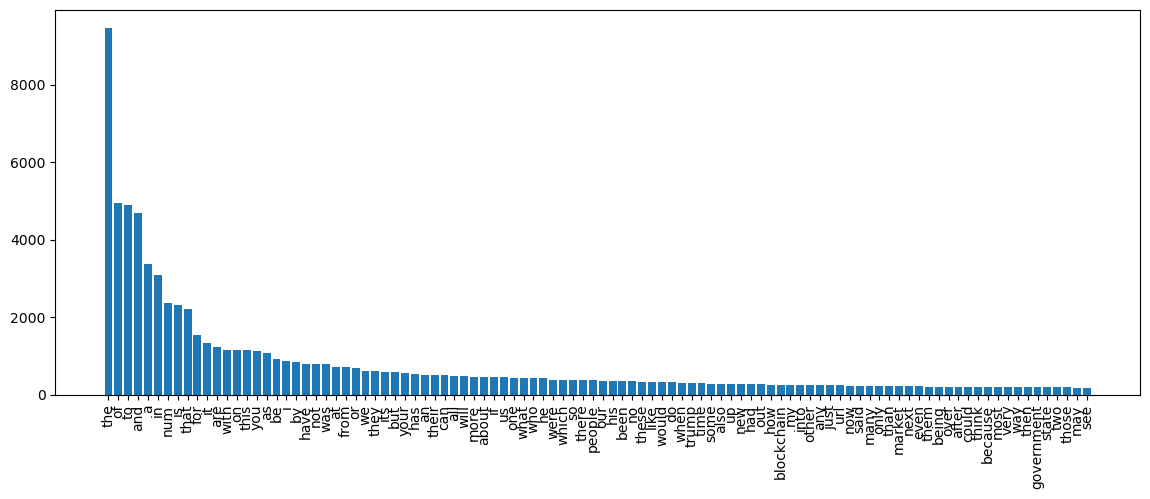

In [32]:
token_x_list = [x for x,_ in token_word_count[0:100]]
token_y_list = [y for _,y in token_word_count[0:100]]


plt.figure(figsize=(14,5))
bar_plot = plt.bar(x=token_x_list, height=token_y_list)
plt.xticks(token_x_list, rotation="vertical")

plt.show()


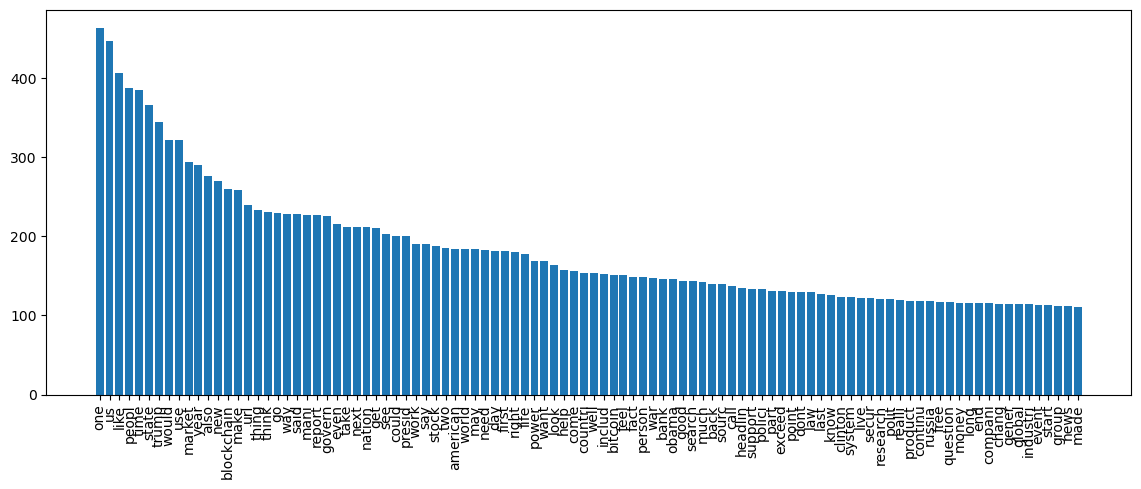

In [33]:
stemmed_x_list = [x for x,_ in stemmed_word_count[0:100]]
stemmed_y_list = [y for _,y in stemmed_word_count[0:100]]

plt.figure(figsize=(14,5))
bar_plot = plt.bar(x=stemmed_x_list, height=stemmed_y_list)
plt.xticks(stemmed_x_list, rotation='vertical')
plt.show()

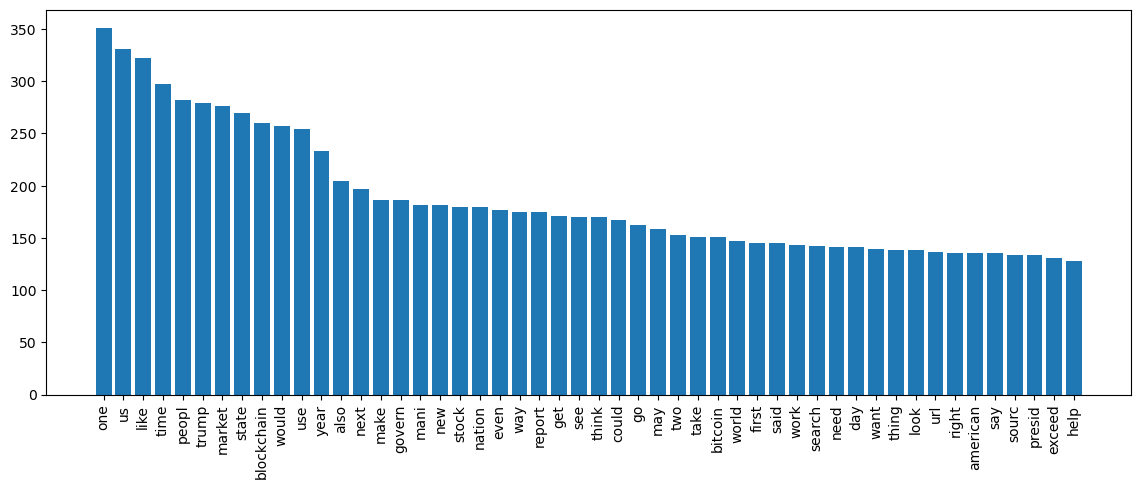

In [34]:
fake_x_list = [x for x,_ in fake_word_count[0:50]]
fake_y_list = [y for _,y in fake_word_count[0:50]]

plt.figure(figsize=(14,5))
bar_plot = plt.bar(x=fake_x_list, height=fake_y_list)
plt.xticks(fake_x_list, rotation='vertical')
plt.show()

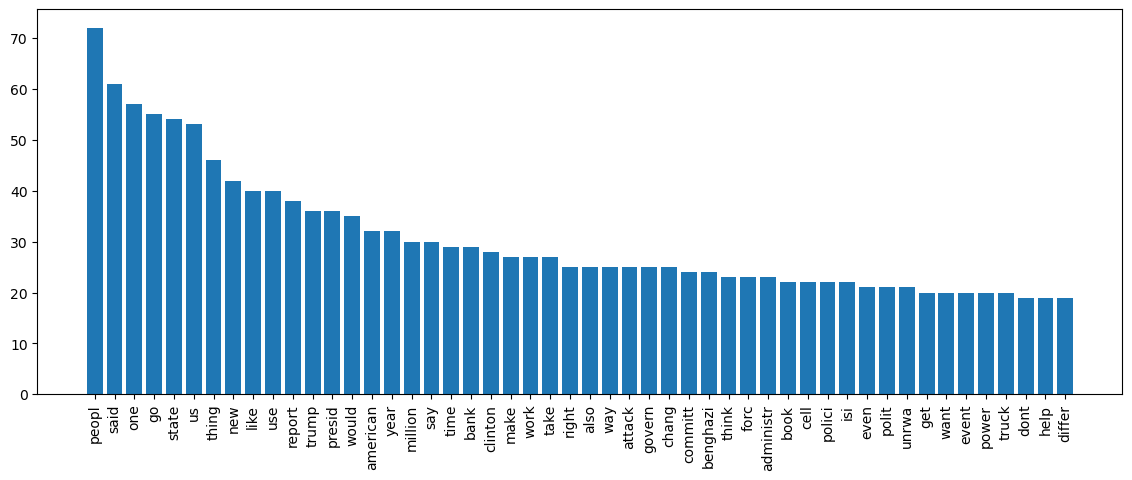

In [35]:
true_x_list = [x for x,_ in true_word_count[0:50]]
true_y_list = [y for _,y in true_word_count[0:50]]

plt.figure(figsize=(14,5))
bar_plot = plt.bar(x=true_x_list, height=true_y_list)
plt.xticks(true_x_list, rotation='vertical')
plt.show()

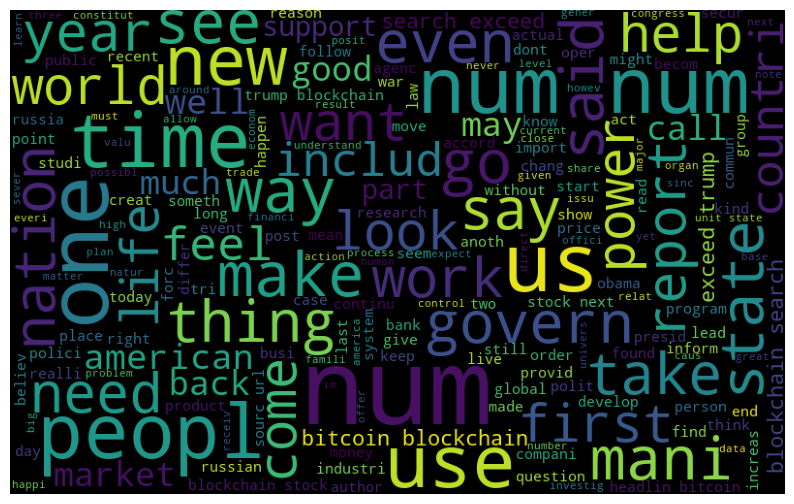

In [36]:
all_words = ' '.join(news_file_stemmed)
wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

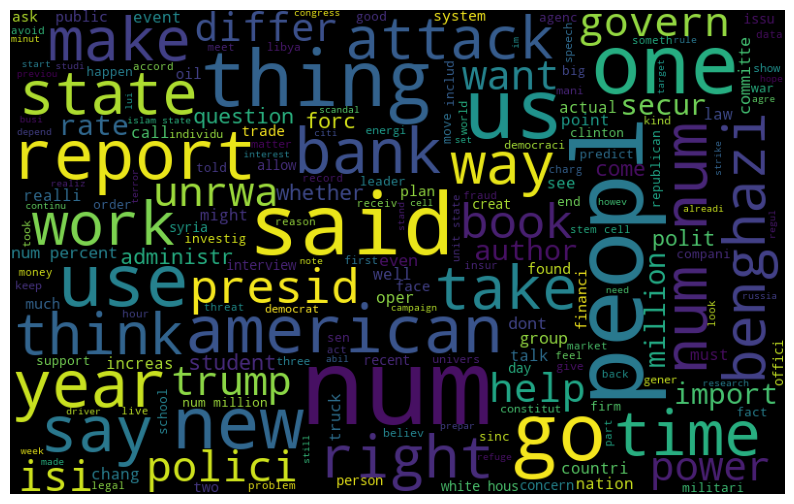

In [37]:
true_words =' '.join([text for text in df['content'][df['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(true_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud,)
plt.axis("off")
plt.show()

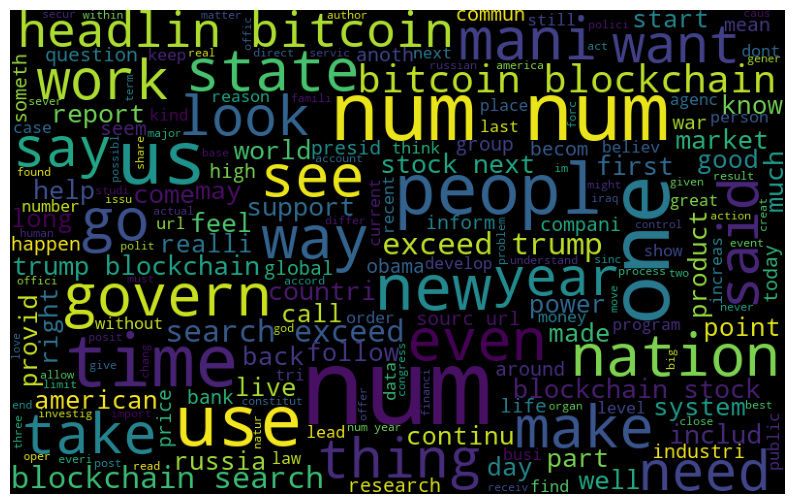

In [38]:
fake_words =' '.join([text for text in df['content'][df['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(fake_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud,)
plt.axis('off')
plt.show()

Insights into the dataset. 
us is one of the most frequently used words our corpus. That seems a bit weird, and I think thats its because our article are mainly US based, so the us is probably mainly used as US. 

When listing the 100 most frequent words, but only of articles with the type fake, we can see that some words moves up in ranking, in particular bitcoin, blockchain, stock and market is at a higher ranking. 

Maybe a bit surprisingly trump is at the same rank he was in compared to the most frequent words of all articles. 

In [39]:
fake_df = df[df["type"].isin(fake_list)]

In [40]:
true_df = df[df["type"].isin(["political", "reliable" , "clickbait"])]

In [41]:
true_df["A_length"] = true_df["content"].str.len()

/tmp/ipykernel_189575/2337451281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df["A_length"] = true_df["content"].str.len()


In [42]:
true_df["A_length"].mean()

2323.153846153846

In [43]:
fake_df["A_length"] = fake_df["content"].str.len()

/tmp/ipykernel_189575/2686498044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df["A_length"] = fake_df["content"].str.len()


In [44]:
fake_

NameError: name 'fake_' is not defined

In [ ]:
df["domain"].head()

In [ ]:
df.groupby(by='domain')['label'].sum()